# Interactive Marsquake Location

Since humanity currently only operates a single seismometer on Mars, we cannot use traditional methods, such as triangulation between several stations to locate a quake. Instead, we need to separate the problem into two parts:
1. Determine the Distance
2. Determine the Direction (Backazimuth)

## Lesson 1: Distance

To determine the distance, we pick a P-wave and an S-wave arrival and then try to find the distance that matches the differential travel time between the two. Typically, P-waves travel about 1.7 times faster, or $v_P=\sqrt{3}V_S$ in a Poisson medium. Using mineral physics, researchers came up with reasonable predictions for the seismic velocity profile of Mars, even before we had any seismic data.
For our case, we use a velocity model called *InSight_KKS21GP*, that was based on the first full mantle-dataset presented in *Stähler et al. (2021)*.

### What to do:
In the left column, you see 3 seismograms, first the vertical component, then the one pointing in North/South direction, then the East/West one. The seismograms are real data from Mars, for the **S0235b** marsquake, that happened on 2019-07-26T12:15:38 or the 235th Martian day after landing (hence the name). 

This quake has relatively clear P- and S-wave arrivals. You can pick them using the two sliders above the figure. 
The sliders are a bit tricky to use. Use the left and right arrow keys to increase/decrease by one second, page up/down to go in 5 second steps.

After picking two times, you'll see that the plot in the right column, a *traveltime distance plot* obtains a marker at the combination of $t_P$, $t_S$ that you picked, as well as the corresponding distance. Note that there are values of $t_S - t_P$, for which no distance can be found, e.g. for $t_S<t_P$ or differences above 500 seconds. Both of these values are unphysical and most likely mean that you picked the wrong phase.

The dropdown box below allows you to pick another event. Pick **S0173a** next. You'll notice that the identification of *P* and *S* is far more difficult here. Specifically, there are a handful of long-period, high amplitude signals in the way. We call them *glitches* and they are likely a tiny cracking in the seismometer casing due to temperature changes. Select *Plot spectrograms* to see a spectrogram instead of a waveform. This can make it much easier to detect a phase arrival in presence of noise.

If you want to pick any of the other quakes, the spectrogram is usually much more helpful than the seismometer.

In the lowest row you see a map of Mars, with a circle that corresponds to the distance that you just picked. Can you spot a tectonic feature that might correspond to your location?

Locate_1(children=(VBox(children=(HBox(children=(IntSlider(value=150, description='P-arrival', max=1200), IntS…

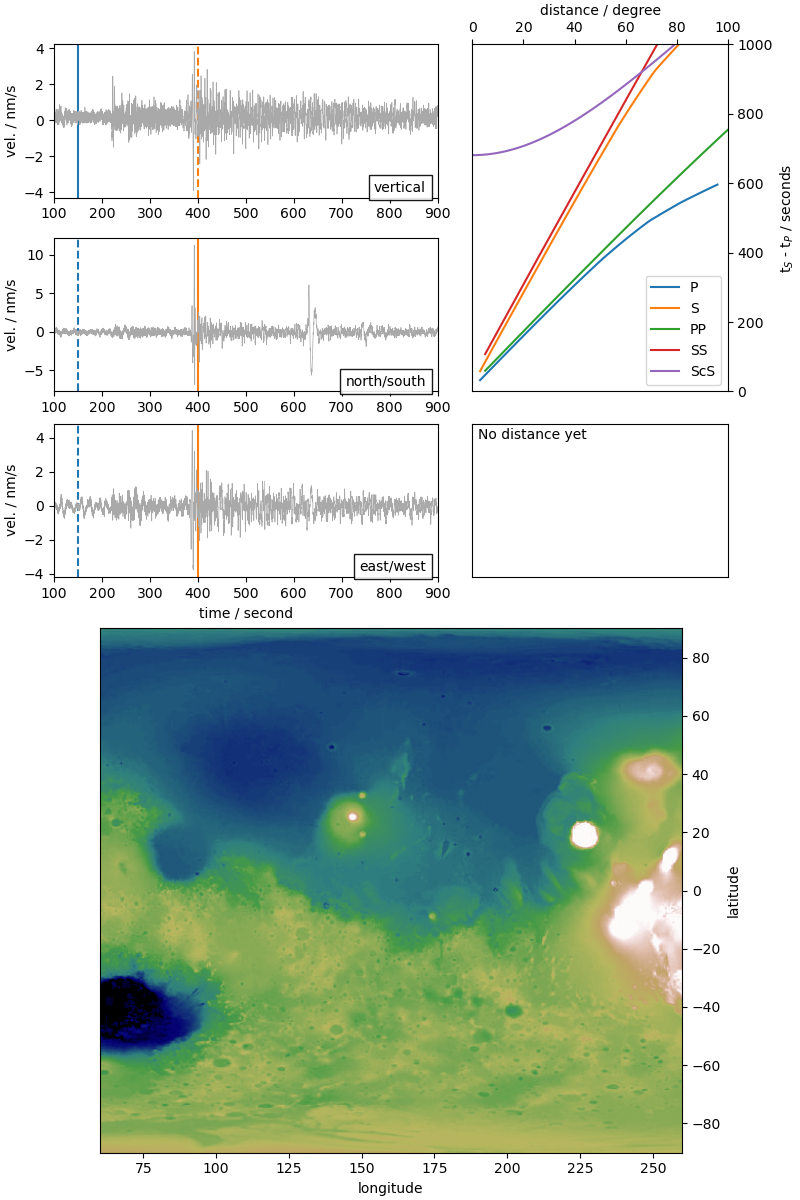

In [1]:
%matplotlib widget

from helpers.locate_1 import Locate_1

Locate_1()